## Programming Exercise 4: Neural Networks Learning

#### Setup

In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import Image

data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')

In [2]:
# Padded with the ones at the beggining
X, y = np.c_[np.ones((data['X'].shape[0],1)), data['X']], data['y'] 
# Showing that the weights contains theta1 and theta2
weights.keys()

['Theta2', '__version__', '__header__', 'Theta1', '__globals__']

#### Displaying the Data

In [3]:
def display_data(x):
    im_number = 200
    imv = np.empty((20,0))
    imag = []
    for i in range(im_number):
        im = np.reshape(x[i],(20,20)).T
        imv = np.append(imv,im,axis=1)
        if (i+1) % 20 == 0:
            imag.append(imv)
            imv = np.empty((20,0))
    image = np.concatenate((imag[:]),axis = 0)
    plt.axis('off')
    plt.imshow(image, cmap = 'gray_r')

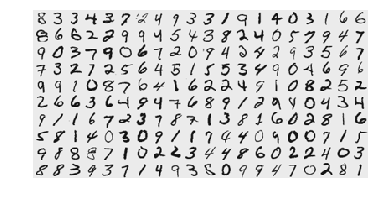

In [9]:
np.random.shuffle(data['X'])
display_data(data['X'])
plt.show()

#### Model Representation
Taken from the assignment's documentation:

![Model](img/Neural_Network_Model.png)

#### Cost Function

##### Gradients

In [5]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def sigmoid_gradient(x):
    return sigmoid(x) * (1 - sigmoid(x))

##### The actual functions

In [104]:
def feed_forward(*args):
    X, y, theta1, theta2 = args
    
    # FF neural network
    ## Since X is already padded with 1 we don't need to add ones
    a1 = X 
    ## Calculating the Hidden Layer
    a2 = sigmoid(X.dot(theta1.T))
    ## Then adding 1s
    a2 = np.c_[np.ones((a2.shape[0],1)), a2]
    ## Calculating the hypothesis
    h_thx = sigmoid(a2.dot(theta2.T))
    
    return a1, a2, h_thx
    

def calculate_cost(nn_params, num_labels, X, y, reg):
    # Extracting the Thetas
    theta1 = nn_params['Theta1']
    theta2 = nn_params['Theta2']
    
    # Setuping some variables
    m = X.shape[0]
    J = 0
    theta1_grad = np.zeros((theta1.shape))
    theta2_grad = np.zeros((theta2.shape))
    
    # Regularization Function for the Cost
    regfunc = float(reg) / (2. * m) * (np.square(theta1).sum() + np.square(theta2).sum())
    
    # Getting the output from the feedforward
    _, _, h_thx = feed_forward(X,y, theta1, theta2)
    
    
    # Calculating the Cost Function
    for label in xrange(num_labels):
        y_label = y == label + 1 # since python indexing starts from 0
        h = h_thx[:,label].reshape(-1,1)
        J_label = - 1. / m * (np.log(h).T.dot(y_label) + np.log(1 - h).T.dot(1 - y_label))
        J = J + J_label
        
    return (J + regfunc)

def calculate_grads(nn_params, num_labels, X, y, reg):
    # Extracting the Thetas
    theta1 = nn_params['Theta1']
    theta2 = nn_params['Theta2']
    
    # Setuping some variables
    m = X.shape[0]
    J = 0
    theta1_grad = np.zeros((theta1.shape))
    theta2_grad = np.zeros((theta2.shape))
    
    # Getting Forward Function
    a1, a2, h_thx = feed_forward(X,y, theta1, theta2)
    
    delta_3 = np.zeros((num_labels, 1))
    delta_2 = np.zeros((theta2.shape[1],1))
    z2 = a1.dot(theta1.T)
    
    # -- for each sample point
    for t in xrange(m):
        for label in xrange(num_labels):
            y_label = y[t,:] == label + 1
            delta_3[label,:] = h_thx[t, label] - y_label
            
        delta_2 = theta2.T.dot(delta_3) * sigmoid_gradient(np.insert(z2[t,:], 0, 1.)).reshape(-1,1)
        # Removing the first delta_2 value as it is to connected to +1
        delta_2 = delta_2[1:,:]
        
        theta1_grad = theta1_grad + delta_2.dot(a1[t,:].reshape(-1,1).T)
        theta2_grad = theta2_grad + delta_3.dot(a2[t,:].reshape(-1,1).T)
        
    
    
    theta1_grad = theta1_grad / m
    theta2_grad = theta2_grad / m
    
    theta1_grad[:,1:] = theta1_grad[:,1:] + reg / m * sum(theta1_grad[:,1:])
    theta2_grad[:,1:] = theta2_grad[:,1:] + reg / m * sum(theta2_grad[:,1:])
    
        
    grad = {
        'Theta1': theta1_grad,
        'Theta2': theta2_grad
    }
    
    
    return grad

##### Testing

In [105]:
# Cost Function with Lambda = 0
cost_0 = calculate_cost(weights, 10, X, y, 0)
print "Should be about 0.287629: %f" % (cost_0)
# Cost Function with Lambda = 1; Should be equal to 0.383770
cost_1 = calculate_cost(weights, 10, X, y, 1)
print "Should be about 0.383770: %f" % (cost_1)

# Testing Sigmoid Gradient
tst = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoid_gradient(tst)
print "Sigmoid Gradient. The 3rd value should be 0.25: " + str(g)

Should be about 0.287629: 0.287629
Should be about 0.383770: 0.384488
Sigmoid Gradient. The 3rd value should be 0.25: [ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]


#### Random Initialization
Selecting values uniformly in the range [-0.12, 0.12]

In [106]:
def rand_init_weights(l_in, l_out, num_labels):
    w_hidden_layer = np.random.uniform(0,1,(l_out, l_in + 1)) * 2 * 0.12 - 0.12
    w_output = np.random.uniform(0,1,(num_labels, w_hidden_layer.shape[0] + 1)) * 2 * 0.12 - 0.12
    
    # Combining to be consistent with the input of the nn cost function
    return {
        'Theta1':w_hidden_layer,
        'Theta2':w_output
    }

##### Initial Thetas

In [107]:
initial_weights = rand_init_weights(400, 25, 10)

#### Checking the Numerical Gradients

In [113]:
def calc_num_grad(J, theta):
    
    # Extracting the thetas
    theta1 = theta['Theta1']
    theta2 = theta['Theta2']
    
    numgrad1 = np.zeros(theta1.shape)
    perturb1 = np.zeros(theta1.shape)
    numgrad2 = np.zeros(theta2.shape)
    perturb2 = np.zeros(theta2.shape)
    
    e = 0.0001

    for p1 in xrange(0, theta1.shape[1]):
        for p2 in xrange(0, theta1.shape[0]):
            perturb1[p2, p1] = e
            loss1 = J({'Theta1':(theta1 - perturb1), 'Theta2':theta2})
            loss2 = J({'Theta1':(theta1 + perturb1), 'Theta2':theta2})

            numgrad1[p2, p1] = (loss2 - loss1) / (2*e)
            perturb1[p2, p1] = 0
            
    for p1 in xrange(0, theta2.shape[1]):
        for p2 in xrange(0, theta2.shape[0]):
            perturb2[p2, p1] = e
            loss1 = J({'Theta1': theta1, 'Theta2':(theta2 - perturb2)})
            loss2 = J({'Theta1': theta1, 'Theta2':(theta2 + perturb2)})

            numgrad2[p2, p1] = (loss2 - loss1) / (2*e)
            perturb2[p2, p1] = 0
        
    return {'Theta1': numgrad1, 'Theta2': numgrad2}

def gradient_check(reg):
    # Define the initial parameters for the test
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # Initializing Theta
    initial_grad = rand_init_weights(input_layer_size, hidden_layer_size, num_labels)
    theta1 = initial_grad['Theta1']
    theta2 = initial_grad['Theta2']
    
    # Generating X
    X = np.random.rand(m, input_layer_size)
    # Padding X with ones
    X = np.c_[np.ones((X.shape[0],1)), X]
    # Generating Y
    y = np.array([np.mod(i,num_labels) + 1 for i in xrange(1,m + 1)]).reshape(-1,1)
    
    # Calculating the resulting gradient
    grad = calculate_grads(initial_grad, num_labels, X, y, reg)
    
    num_grad = calc_num_grad(lambda theta: calculate_cost(theta, num_labels, X, y, reg), initial_grad)


    flat_grad = np.hstack([grad['Theta1'].ravel(), grad['Theta2'].ravel()])
    flat_num_grad = np.hstack([num_grad['Theta1'].ravel(), num_grad['Theta2'].ravel()])
    
    print 'Calculated Gradient, Numerical Gradient'
    for i in range(len(flat_grad)):
        print (flat_grad[i], flat_num_grad[i]) 
    
    print 
    diff = np.linalg.norm(flat_num_grad - flat_grad) / np.linalg.norm(flat_num_grad + flat_grad)
    print 'Relative Difference: '
    print diff

In [114]:
gradient_check(0)

Calculated Gradient, Numerical Gradient
(0.0088388604553853445, 0.0088388604480016397)
(0.0030080527089648935, 0.0030080527091413956)
(0.0046598027591463094, 0.0046598027569899614)
(0.0037028637855599372, 0.0037028637844827017)
(0.0052084072142793616, 0.0052084072077462906)
(0.00031836025759871369, 0.0003183602603762381)
(0.0032565033476203223, 0.0032565033447617964)
(0.002441110374971881, 0.0024411103716204252)
(0.0049473194035757027, 0.0049473193985960506)
(0.0028780401432895466, 0.0028780401417627388)
(0.0025877796688004847, 0.0025877796683282384)
(0.0022026667510813523, 0.0022026667489960516)
(0.0081631427691280754, 0.008163142763972786)
(0.0036753023855552692, 0.0036753023846536337)
(0.0040222804335948827, 0.0040222804331691009)
(0.0032871023790245258, 0.0032871023769587282)
(-0.00070136464023311219, -0.00070136463969916463)
(0.0005018437784511619, 0.00050184377764495025)
(-0.00043173616593094488, -0.00043173616459668551)
(-0.00025556373329878752, -0.00025556373461910198)
(0.35620

**The relative difference above should be smaller than 1e-9**